# Cài đặt thư viện cần thiết

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!pip install optuna
!pip install xgboost
!pip install catboost


In [3]:
result = {}

In [4]:
df_full_data = pd.read_csv('df_full_data.csv')
full_data_4_6 = pd.read_csv('full_data_4_6.csv')
full_data_7_9 = pd.read_csv('full_data_7_9.csv')

full_data_4_6_cleaned = pd.read_csv('full_data_4_6_cleaned.csv')
full_data_7_9_cleaned = pd.read_csv('full_data_7_9_cleaned.csv')
df_full_data_cleaned = pd.read_csv('df_full_data_cleaned.csv')

In [5]:
full_data_4_6

,Stock class,OTHER AREA SHIP DIV,SPECIAL DIV,LOGICAL PLANT,DELI_DIV,Ship Mode,SUPPLIER_DIV,Order date,BRAND_CD,SO QTY,PURCHASE AMOUNT,WEIGHT PER PIECE,SO_DAY_OF_MONTH,label,CLASSIFY_CD,PRODUCT ATTRIBUTION,SO_TIME,SO_DAY_OF_WEEK,VSD
0,1,-1.0,0,55,00,S,3.0,2022-04-04,HAK1,1,8700,12,4,1,21034701,1,120324,1,2022-04-13 00:00:00
1,1,-1.0,0,53,00,B,3.0,2022-04-26,S3M1,10,15350,200,26,1,23028764,1,171618,2,2022-06-10 00:00:00
2,1,-1.0,0,53,00,S,2.0,2022-04-19,THT1,1,900,5,19,1,21059031,1,184619,2,2022-05-07 00:00:00
3,1,-1.0,0,53,00,Q,1.0,2022-04-22,MSM1,1,1551,43,22,1,3731227,1,93246,5,2022-04-27 00:00:00
4,1,-1.0,0,53,00,B,1.0,2022-04-22,MSM1,2,376,270,22,1,3954111,1,153401,5,2022-04-27 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399048,1,-1.0,0,55,00,H,1.0,2022-06-21,MSM1,1,364,95,21,0,3643112,1,142414,2,2022-06-27 00:00:00
399049,1,-1.0,0,55,00,S,1.0,2022-05-20,MSM1,10,1810,5,20,0,3632307,1,170033,5,2022-07-04 00:00:00
399050,1,-1.0,0,53,00,T,1.0,2022-04-07,MSM1,4,1600,30,7,0,2042002,1,170410,4,2022-04-11 00:00:00
399051,1,-1.0,0,52,40,T,1.0,2022-04-14,MSM1,20,400,2,14,0,3733118,1,92222,4,2022-04-15 00:00:00


In [6]:
nominal = ['SUBSIDIARY_CD','GLOBAL_NO','CLASSIFY_CD','CUST_CD','BRAND_CD','INNER_CD','SUPPLIER_CD','Stock class','Consider count hodiday Saturday','OTHER AREA SHIP DIV','PRODUCT_CD','PRODUCT ATTRIBUTION','SPECIAL DIV','LOGICAL PLANT','DIRECT SHIP FLG','DELI_DIV','Ship Mode','SHIP DECISION NO','SUPPLIER_DIV','SPECIAL_DIV','QTUF_RCV_NO','SOUF_RCV_NO','Order date' ,'VSD','SO_TIME']

ordinal = ['PACKING RANK']

discrete = ['Sales order line number', 'Consider count hodiday Saturday','SO QTY','ALLOCATION QTY','SUPPLIER INV AMOUNT','PURCHASE AMOUNT','PACK QTY','WEIGHT PER PIECE','SO_DAY_OF_MONTH','SO_DAY_OF_WEEK','WEIGHT']

missing_columns = ['OTHER AREA SHIP DIV',
 'Ship Mode',
 'SHIP DECISION NO',
 'SUPPLIER_DIV',
 'REASON_CD',
 'SOUF_RCV_NO',
 'QTUF_RCV_NO']

number = ['SO QTY','WEIGHT PER PIECE','PURCHASE AMOUNT']

# Xác định phân phối của các biến category để sử dụng count encoding

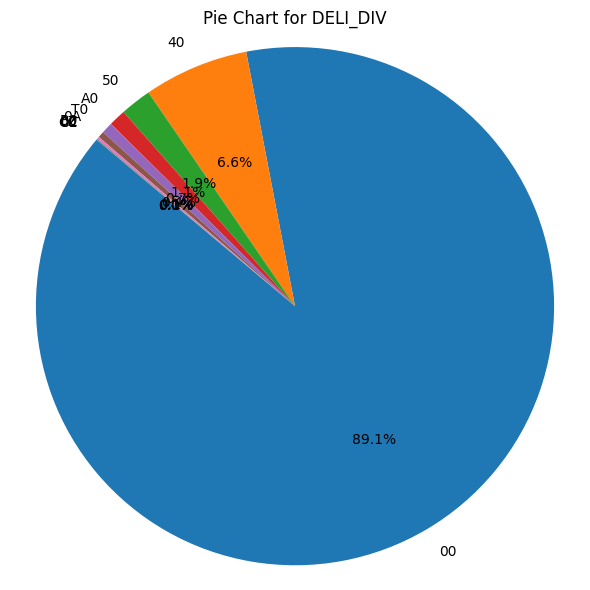

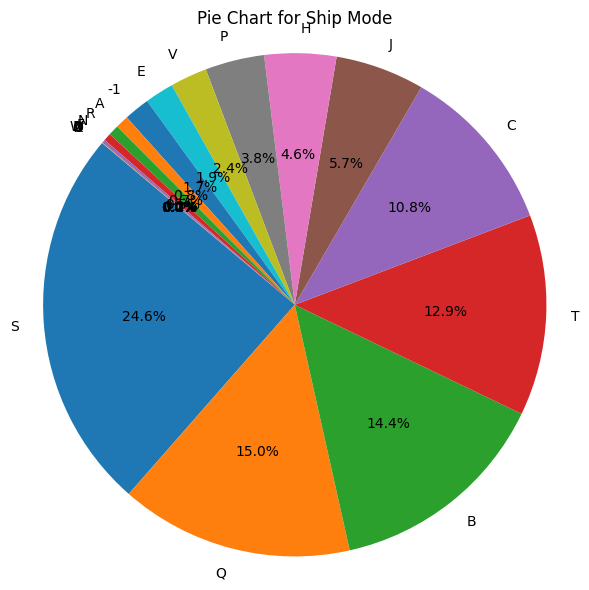

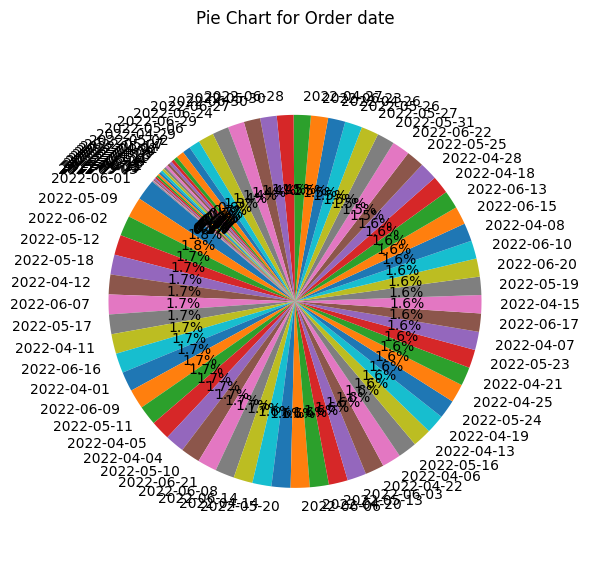

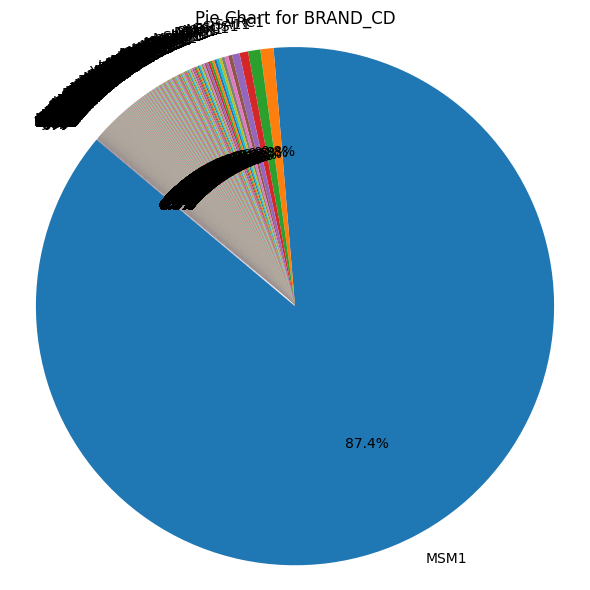

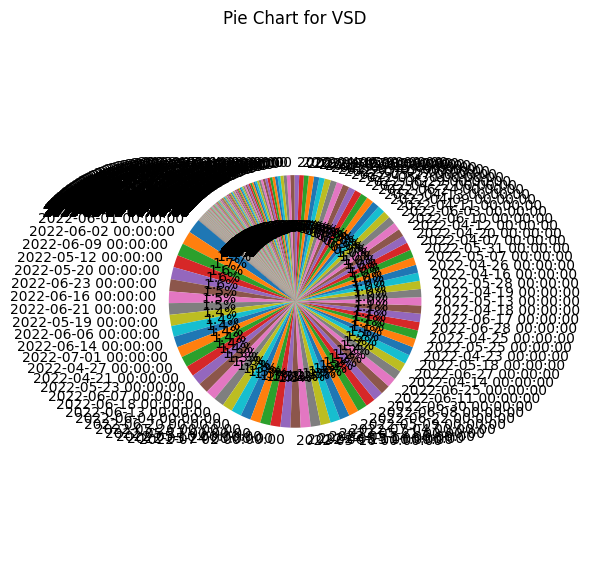

In [7]:
# Chọn các cột object
object_columns = full_data_4_6.select_dtypes(include='object').columns.tolist()

# Vẽ pie chart cho từng cột
for col in object_columns:
    value_counts = full_data_4_6[col].value_counts(normalize=True)  # Lấy tỉ lệ %
    labels = value_counts.index
    sizes = value_counts.values

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie Chart for {col}')
    plt.axis('equal')  # Đảm bảo hình tròn
    plt.tight_layout()
    plt.show()


Hàm Encode cho model học

In [8]:
def encode_object_columns(df, count_encode_cols, label_encode_cols):
    """
    Kết hợp count encoding và label encoding cho các cột khác nhau.

    Parameters:
        df (pd.DataFrame): DataFrame đầu vào.
        count_encode_cols (list): Danh sách các cột cần count encode.
        label_encode_cols (list): Danh sách các cột cần label encode.

    Returns:
        df_encoded (pd.DataFrame): DataFrame sau mã hóa.
        encoding_maps (dict): Từ điển lưu mapping cho từng cột.
            - Với count encoding: category -> count
            - Với label encoding: category -> code
    """
    df_encoded = df.copy()
    encoding_maps = {}

    # Count encoding
    for col in count_encode_cols:
        counts = df_encoded[col].value_counts()
        df_encoded[col] = df_encoded[col].map(counts)
        encoding_maps[col] = counts.to_dict()

    # Label encoding
    for col in label_encode_cols:
        df_encoded[col] = df_encoded[col].astype('category')
        codes = dict(enumerate(df_encoded[col].cat.categories))
        df_encoded[col] = df_encoded[col].cat.codes
        encoding_maps[col] = {v: k for k, v in codes.items()}  # category -> code

    return df_encoded


In [9]:
def convert_column_types(df, nominal, ordinal):
    """
    Chuyển kiểu dữ liệu của các cột trong DataFrame:
    - Các cột trong nominal + ordinal → str
    - Các cột còn lại → int64

    Parameters:
        df (pd.DataFrame): DataFrame đầu vào.
        nominal (list): Danh sách các biến định tính (nominal).
        ordinal (list): Danh sách các biến thứ bậc (ordinal).

    Returns:
        pd.DataFrame: DataFrame sau khi chuyển kiểu dữ liệu.
    """
    target = ['label']
    df_converted = df.copy()
    for column in df_converted.columns:
        if column in nominal + ordinal:
            df_converted[column] = df_converted[column].astype(str)
        elif column in discrete + target:
            df_converted[column] = df_converted[column].astype('int64')
        else: 
            pass
    return df_converted


In [10]:
df_full_data = convert_column_types(df_full_data, nominal, ordinal)
full_data_7_9 = convert_column_types(full_data_7_9, nominal, ordinal)
full_data_4_6 = convert_column_types(full_data_4_6, nominal, ordinal)

df_full_data_cleaned = convert_column_types(df_full_data_cleaned, nominal, ordinal)
full_data_4_6_cleaned = convert_column_types(full_data_4_6_cleaned, nominal, ordinal)
full_data_7_9_cleaned = convert_column_types(full_data_7_9_cleaned, nominal, ordinal)
df_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473950 entries, 0 to 1473949
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Stock class          1473950 non-null  object
 1   OTHER AREA SHIP DIV  1473950 non-null  object
 2   SPECIAL DIV          1473950 non-null  object
 3   LOGICAL PLANT        1473950 non-null  object
 4   DELI_DIV             1473950 non-null  object
 5   Ship Mode            1473950 non-null  object
 6   SUPPLIER_DIV         1473950 non-null  object
 7   Order date           1473950 non-null  object
 8   BRAND_CD             1473950 non-null  object
 9   SO QTY               1473950 non-null  int64 
 10  PURCHASE AMOUNT      1473950 non-null  int64 
 11  WEIGHT PER PIECE     1473950 non-null  int64 
 12  SO_DAY_OF_MONTH      1473950 non-null  int64 
 13  label                1473950 non-null  int64 
 14  CLASSIFY_CD          1473950 non-null  object
 15  PRODUCT ATTRIBU

In [11]:
object_columns = full_data_4_6.select_dtypes(include='object').columns.tolist()

count_encode_cols = object_columns.copy()   
label_encode_cols =['Order date']

In [12]:
df_full_data_encoded = encode_object_columns(df_full_data, count_encode_cols, label_encode_cols)
full_data_7_9_encoded = encode_object_columns(full_data_7_9, count_encode_cols, label_encode_cols)
full_data_4_6_encoded = encode_object_columns(full_data_4_6, count_encode_cols, label_encode_cols)

df_full_data_cleaned_encoded = encode_object_columns(df_full_data_cleaned, count_encode_cols, label_encode_cols)
full_data_4_6_cleaned_encoded = encode_object_columns(full_data_4_6_cleaned, count_encode_cols, label_encode_cols)
full_data_7_9_cleaned_encoded = encode_object_columns(full_data_7_9_cleaned, count_encode_cols, label_encode_cols)

## Check outlier

In [13]:
def remove_outliers_iqr(df, columns):
    """
    Phát hiện và loại bỏ outliers trong nhiều cột số bằng phương pháp IQR.
    Đồng thời kiểm tra các giá trị âm trong các cột đó.

    Args:
        df (pd.DataFrame): DataFrame gốc.
        columns (list): Danh sách tên các cột cần xử lý.

    Returns:
        cleaned_df (pd.DataFrame): DataFrame sau khi loại bỏ outliers ở tất cả các cột.
        outliers_info (dict): Thông tin chi tiết outliers cho từng cột.
    """
    cleaned_df = df.copy()
    outliers_info = {}

    for column in columns:
        data = cleaned_df[column]
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        mask_outliers = (data < lower_bound) | (data > upper_bound)
        outliers_df = cleaned_df[mask_outliers]
        outlier_indices = outliers_df.index.tolist()

        # Kiểm tra các giá trị âm
        negative_indices = cleaned_df[data < 0].index.tolist()

        # Cập nhật thông tin
        outliers_info[column] = {
            'outliers_df': outliers_df,
            'outlier_indices': outlier_indices,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'negative_indices': negative_indices
        }

        # Loại bỏ outliers ở cột này
        cleaned_df = cleaned_df[~mask_outliers]

    return cleaned_df


# Xử lí imbalanced - undersampling - 1:5

In [14]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
from imblearn.under_sampling import RandomUnderSampler

def apply_random_undersampling(df, label_col='label', desired_ratio=1/5, random_state=42):
    """
    Thực hiện undersampling để đạt được tỷ lệ thiểu số:đa số mong muốn (ví dụ: 1:5).

    Parameters:
    - df (pd.DataFrame): Dữ liệu đầu vào.
    - label_col (str): Tên cột nhãn (label).
    - desired_ratio (float): Tỷ lệ thiểu số:đa số sau khi undersample (vd: 1/5).
    - random_state (int): Seed để tái lập kết quả.

    Returns:
    - pd.DataFrame: DataFrame sau khi undersample.
    """
    X = df.drop(columns=[label_col])
    y = df[label_col]

    # Đếm số lượng mẫu từng lớp
    class_counts = y.value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()
    n_minority = class_counts[minority_class]
    n_majority_target = int(n_minority / desired_ratio)

    # Đảm bảo không lấy nhiều hơn dữ liệu hiện có
    n_majority_target = min(n_majority_target, class_counts[majority_class])

    sampling_strategy = {
        minority_class: n_minority,
        majority_class: n_majority_target
    }

    undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
    return df_resampled


# **Model**

## LightGBM

In [16]:
from sklearn.preprocessing import LabelEncoder

def label_encode_df(df, columns):
    """
    Encode các biến phân loại bằng LabelEncoder.
    
    Args:
        df (DataFrame): Dữ kiện bạn muốn mã hoá.
        columns (list of str): Danh sách các dòng cần mã hoá.

    Returns:
        DataFrame: Dữ kiện sau khi được mã hoá.
    """
    df = df.copy()
    label = LabelEncoder()
    for col in columns:
        df[col] = label.fit_transform(df[col].astype(str))
    return df


# Cách sử dụng:
category_columns = ['Stock class', 'OTHER AREA SHIP DIV',
                    'SPECIAL DIV', 'LOGICAL PLANT',
                    'DELI_DIV', 'Ship Mode',
                    'SUPPLIER_DIV', 'BRAND_CD', 'Order date','CLASSIFY_CD','PRODUCT ATTRIBUTION','VSD']

df_full_data_encoded = label_encode_df(df_full_data_encoded, category_columns)
df_full_data_cleaned_encoded = label_encode_df(df_full_data_cleaned_encoded, category_columns)

In [17]:
df_full_data_encoded.dtypes

Stock class            int32
OTHER AREA SHIP DIV    int32
SPECIAL DIV            int32
LOGICAL PLANT          int32
DELI_DIV               int32
Ship Mode              int32
SUPPLIER_DIV           int32
Order date             int32
BRAND_CD               int32
SO QTY                 int64
PURCHASE AMOUNT        int64
WEIGHT PER PIECE       int64
SO_DAY_OF_MONTH        int64
label                  int64
CLASSIFY_CD            int32
PRODUCT ATTRIBUTION    int32
SO_TIME                int64
SO_DAY_OF_WEEK         int64
VSD                    int32
dtype: object

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import numpy as np
from catboost import CatBoostClassifier, Pool

# ------------------------------------------------------------------------------
# 1. Chuẩn bị dữ kiện
# ------------------------------------------------------------------------------
# Giả sử bạn vẫn sử dụng df_full_data_encoded, label
X_all = df_full_data_encoded.drop(columns=['label'])

y_all = df_full_data_encoded['label'].astype(int)
print("X_all shape :", X_all.shape)


# ------------------------------------------------------------------------------
# 2. Tách train, validation, test
# ------------------------------------------------------------------------------
train_idx, temp_idx = train_test_split(
    X_all.index,
    test_size=0.4,
    random_state=42,
    stratify=y_all
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=42,
    stratify=y_all.loc[temp_idx]
)

print(f"Train size: {len(train_idx)}")
print(f"Validation size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")

# ------------------------------------------------------------------------------
# 3. Chuẩn bị dữ kiện huấn luyện
# ------------------------------------------------------------------------------
df_train = df_full_data_encoded.loc[train_idx].copy()
df_train = apply_random_undersampling(
    df_train,
    label_col='label',
    desired_ratio=1/20
)
X_train = df_train.drop(columns=['label'])

y_train = df_train['label'].astype(int)

# ------------------------------------------------------------------------------
# 4. Chuẩn bị dữ kiện validation
# ------------------------------------------------------------------------------
X_val = df_full_data_encoded.loc[val_idx].drop(columns=['label'])

y_val = df_full_data_encoded.loc[val_idx, 'label'].astype(int)

# ------------------------------------------------------------------------------
# 5. Chuẩn bị dữ kiện test
# ------------------------------------------------------------------------------
X_test = df_full_data_encoded.loc[test_idx].drop(columns=['label'])

y_test = df_full_data_encoded.loc[test_idx, 'label'].astype(int)

print("Train size (after undersampling):", X_train.shape)
print("Validation size (raw data):", X_val.shape)
print("Test size (raw data):", X_test.shape)


# ------------------------------------------------------------------------------
# 6. Huấn luyện CatBoost mà KHÔNG grid search
# ------------------------------------------------------------------------------
model = CatBoostClassifier(
    random_seed=42,
    depth=6,
    learning_rate=0.05,
    iterations=1000,
    l2_leaf_reg=3,
    cat_features=category_columns,
    early_stopping_rounds=100,
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)


# ------------------------------------------------------------------------------
# 7. Dùng mô hình để dự đoán
# ------------------------------------------------------------------------------
y_pred = model.predict(X_test)
print("Predictions finished.")
print("F1-test =", f1_score(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy-test =", accuracy_score(y_test, y_pred))


X_all shape : (1473950, 18)
Train size: 884370
Validation size: 294790
Test size: 294790
Train size (after undersampling): (452970, 18)
Validation size (raw data): (294790, 18)
Test size (raw data): (294790, 18)
0:	learn: 0.6116088	test: 0.6088051	best: 0.6088051 (0)	total: 463ms	remaining: 7m 42s
100:	learn: 0.0632486	test: 0.0367546	best: 0.0367546 (100)	total: 29.6s	remaining: 4m 23s
200:	learn: 0.0555232	test: 0.0313527	best: 0.0313527 (200)	total: 1m 8s	remaining: 4m 33s
300:	learn: 0.0532505	test: 0.0300311	best: 0.0300311 (300)	total: 1m 46s	remaining: 4m 7s
400:	learn: 0.0518322	test: 0.0293924	best: 0.0293924 (400)	total: 2m 22s	remaining: 3m 32s
500:	learn: 0.0509530	test: 0.0290946	best: 0.0290946 (500)	total: 2m 57s	remaining: 2m 56s
600:	learn: 0.0502070	test: 0.0288203	best: 0.0288203 (600)	total: 3m 31s	remaining: 2m 20s
700:	learn: 0.0496065	test: 0.0285985	best: 0.0285985 (700)	total: 4m 6s	remaining: 1m 45s
800:	learn: 0.0490916	test: 0.0284449	best: 0.0284449 (800)	t

In [19]:
import pickle

with open("catboost.pkl", "wb") as f:
    pickle.dump(model, f)
print("Mô hình catboost (catboost) đã được pickle.")


Mô hình catboost (catboost) đã được pickle.


In [35]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import numpy as np

# ------------------------------------------------------------------------------
# 1. Chuẩn bị dữ kiện
# ------------------------------------------------------------------------------
# Giả sử bạn vẫn sử dụng df_full_data_encoded, label
X_all = df_full_data_encoded.drop(columns=['label'])

y_all = df_full_data_encoded['label'].astype(int)
print("X_all shape :", X_all.shape)


# ------------------------------------------------------------------------------
# 2. Tách train, validation, test
# ------------------------------------------------------------------------------
train_idx, temp_idx = train_test_split(
    X_all.index,
    test_size=0.4,
    random_state=42,
    stratify=y_all
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=42,
    stratify=y_all.loc[temp_idx]
)

print(f"Train size: {len(train_idx)}")
print(f"Validation size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")

# ------------------------------------------------------------------------------
# 3. Chuẩn bị dữ kiện huấn luyện
# ------------------------------------------------------------------------------
df_train = df_full_data_encoded.loc[train_idx].copy()
df_train = apply_random_undersampling(
    df_train,
    label_col='label',
    desired_ratio=1/20
)
X_train = df_train.drop(columns=['label'])

y_train = df_train['label'].astype(int)

# ------------------------------------------------------------------------------
# 4. Chuẩn bị dữ kiện validation
# ------------------------------------------------------------------------------
X_val = df_full_data_encoded.loc[val_idx].drop(columns=['label'])

y_val = df_full_data_encoded.loc[val_idx, 'label'].astype(int)

# ------------------------------------------------------------------------------
# 5. Chuẩn bị dữ kiện test
# ------------------------------------------------------------------------------
X_test = df_full_data_encoded.loc[test_idx].drop(columns=['label'])

y_test = df_full_data_encoded.loc[test_idx, 'label'].astype(int)

print("Train size (after undersampling):", X_train.shape)
print("Validation size (raw data):", X_val.shape)
print("Test size (raw data):", X_test.shape)


# ------------------------------------------------------------------------------
# 6. Huấn luyện LightGBM mà KHÔNG grid search
# ------------------------------------------------------------------------------
model = lgb.LGBMClassifier(
    random_state=42,
    num_leaves=31,
    max_depth=-1,
    min_data_in_leaf=20,
    learning_rate=0.05
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    categorical_feature=category_columns,
)


# ------------------------------------------------------------------------------
# 7. Dùng mô hình để dự đoán
# ------------------------------------------------------------------------------
y_pred = model.predict(X_test)
print("Predictions finished.")
print("F1-test =", f1_score(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy-test =", accuracy_score(y_test, y_pred))


X_all shape : (1473950, 18)
Train size: 884370
Validation size: 294790
Test size: 294790
Train size (after undersampling): (452970, 18)
Validation size (raw data): (294790, 18)
Test size (raw data): (294790, 18)
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 21570, number of negative: 431400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012585 seconds.
You can set `force_row_wise=true` to remove the overhead.

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report

def evaluate_model(y_true, y_pred, y_pred_proba=None):
    """
    Đánh giá mô hình phân loại với các chỉ số cơ bản.
    
    Args:
        y_true (array-like): Nhãn thật.
        y_pred (array-like): Dự đoán của mô hình.
        y_pred_proba (array-like, optional): Dự đoán xác suất của mô hình nếu có.
    """
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("F1 score :", f1_score(y_true, y_pred, average='macro'))
    print("Precision :", precision_score(y_true, y_pred, average='weighted'))
    print("Recall :", recall_score(y_true, y_pred, average='weighted'))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    if y_pred_proba is not None:
        auc = roc_auc_score(y_true, y_pred_proba)
        print("AUC :", auc)


# Cách sử dụng:
# Giả sử bạn có:
# y_test, y_pred, y_pred_proba
evaluate_model(y_test, y_pred, y_pred_proba=None)


Accuracy : 0.989602768072187
F1 score : 0.8760153084639936
Precision : 0.988934619232774
Recall : 0.989602768072187
Confusion Matrix:
[[286942    658]
 [  2407   4783]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    287600
           1       0.88      0.67      0.76      7190

    accuracy                           0.99    294790
   macro avg       0.94      0.83      0.88    294790
weighted avg       0.99      0.99      0.99    294790



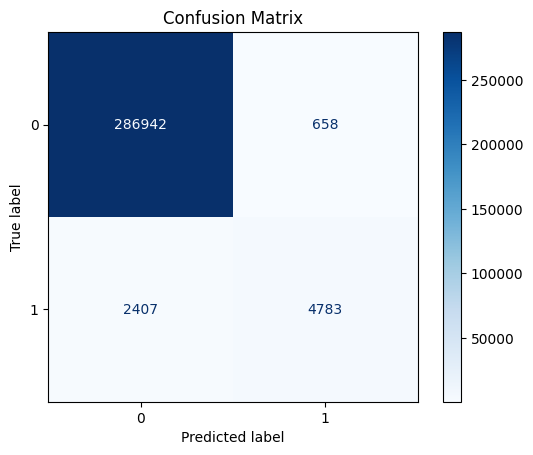

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [38]:
import pickle

with open("lightgbm_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("Mô hình LightGBM (LGBMClassifier) đã được pickle.")


Mô hình LightGBM (LGBMClassifier) đã được pickle.


# presshere

In [203]:
with open("lightgbm_model.pkl", "rb") as f:
    model_new = pickle.load(f)
print("Mô hình LightGBM (LGBMClassifier) được tải lại.")


Mô hình LightGBM (LGBMClassifier) được tải lại.


## XGboost - Đã xử lí IB - A - No Fold

In [38]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
category_columns = ['Stock class','BRAND_CD','Ship Mode','Order date','SUPPLIER_DIV','LOGICAL PLANT','OTHER AREA SHIP DIV','SPECIAL DIV','DELI_DIV']
# 1. X và y từ bản encode gốc
X_all = full_data_4_6.drop(columns=['label'])
# Áp dụng encode toàn bộ trước
y_all = full_data_4_6['label'].astype(int)
print("X_all shape:", X_all.shape)
# 2. Tách chỉ số index cho train/test (80/20)
train_idx, temp_idx = train_test_split(
    X_all.index,
    test_size=0.4,   # 40% còn lại
    random_state=42,
    stratify=y_all
)

# Tách temp_idx thành validation 20% và test 20%
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,   # chia đôi temp_idx thành 20% val + 20% test
    random_state=42,
    stratify=y_all.loc[temp_idx]
)
print(f"Train size: {len(train_idx)} ({len(train_idx)/len(X_all)*100:.1f}%)")
print(f"Validation size: {len(val_idx)} ({len(val_idx)/len(X_all)*100:.1f}%)")
print(f"Test size: {len(test_idx)} ({len(test_idx)/len(X_all)*100:.1f}%)")

# 3. Chuẩn bị df_train 
df_train = full_data_4_6.loc[train_idx].copy()
# Áp dụng remove outliers cho df_train
df_train = remove_outliers_iqr(df_train, number)
# Ap dụng undersampling
df_train_under = apply_random_undersampling(
    df_train,
    label_col='label',
    desired_ratio=1/20
)
# Áp dụng encode cho df_train_under
X_train = df_train_under.drop(columns=['label'])
y_train = df_train_under['label'].astype(int)

# 4. Chuẩn bị df_val 
df_val = full_data_4_6.loc[val_idx].copy()
X_val = df_val.drop(columns=['label'])
y_val = df_val['label'].astype(int)

# 5. Chuẩn bị df_test
df_test = full_data_4_6.loc[test_idx].copy()
X_test = df_test.drop(columns=['label'])
y_test = df_test['label'].astype(int)

# Tạo lại Pool cho val/test nếu dùng CatBoost
val_pool = Pool(X_val, y_val, cat_features=category_columns)
test_pool = Pool(X_test, y_test, cat_features=category_columns)
train_pool = Pool(X_train, y_train, cat_features=category_columns)
# In kết quả để kiểm tra
print("Train size (after undersample):", X_train.shape)
print("Validation size (raw data):", X_val.shape)
print("Test size (raw data):", X_test.shape)


X_all shape: (399053, 12)
Train size (raw data): 359147
Test size (raw data): 39906
Validation size (raw data): 19953
Final test size (raw data): 19953
Train size (after undersample): (27108, 12)
Validation size (raw data): (19953, 12)
Test size (raw data): (19953, 12)


In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

import optuna
def objective(trial):
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'tree_method': 'hist',
        'eval_metric': 'logloss',
        'early_stopping_rounds': 100,
        'scale_pos_weight': scale_pos_weight
    }

    model = XGBClassifier(**params)
    eval_set = [(X_val, y_val)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=False
    )

    preds = model.predict(X_val)
    return f1_score(y_val, preds)


In [40]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)

[I 2025-05-22 09:26:57,234] A new study created in memory with name: no-name-0de76c45-e1bc-4553-89e5-8a8c12f8d6fa
[I 2025-05-22 09:26:57,539] Trial 0 finished with value: 0.06837876161966283 and parameters: {'learning_rate': 0.18449697984664837, 'max_depth': 4, 'subsample': 0.9449621318492627, 'gamma': 2.7869171407487423, 'reg_alpha': 2.06106475296606, 'reg_lambda': 1.4372055871279903}. Best is trial 0 with value: 0.06837876161966283.
[I 2025-05-22 09:26:57,860] Trial 1 finished with value: 0.055673758865248224 and parameters: {'learning_rate': 0.2303624852209885, 'max_depth': 10, 'subsample': 0.9429818508745984, 'gamma': 3.7186631713631293, 'reg_alpha': 2.9224217292174477, 'reg_lambda': 1.9787182483747057}. Best is trial 0 with value: 0.06837876161966283.
[I 2025-05-22 09:26:58,234] Trial 2 finished with value: 0.06771325893701532 and parameters: {'learning_rate': 0.22886976588901195, 'max_depth': 6, 'subsample': 0.7618486460777127, 'gamma': 4.222391457648152, 'reg_alpha': 3.198850145

KeyboardInterrupt: 

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np

# Lấy params tốt nhất từ Optuna
best_params = study.best_trial.params

# Thêm các tham số cố định nếu cần
best_params.update({
    'n_estimators': 1000,
    'eval_metric': 'logloss',  # XGBoost không có f1 làm eval_metric trực tiếp
})

# Khởi tạo mô hình XGBoost
best_model = XGBClassifier(**best_params)

# Huấn luyện mô hình
best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Lấy xác suất dự đoán
y_probs = best_model.predict_proba(X_test)[:, 1]

# ===== Tối ưu threshold theo F1 =====
val_probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_val, val_probs >= t) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f'Best threshold: {best_threshold:.3f}')

# Dự đoán với threshold tối ưu
y_pred_opt = (y_probs >= best_threshold).astype(int)

Best threshold: 0.496


✅ Best Threshold: 0.4960
F1-score       : 0.0679
Precision      : 0.0419
Recall         : 0.1790
AUC ROC        : 0.5265
PR AUC         : 0.0556

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     19467
           1       0.04      0.18      0.07       486

    accuracy                           0.88     19953
   macro avg       0.51      0.54      0.50     19953
weighted avg       0.95      0.88      0.91     19953



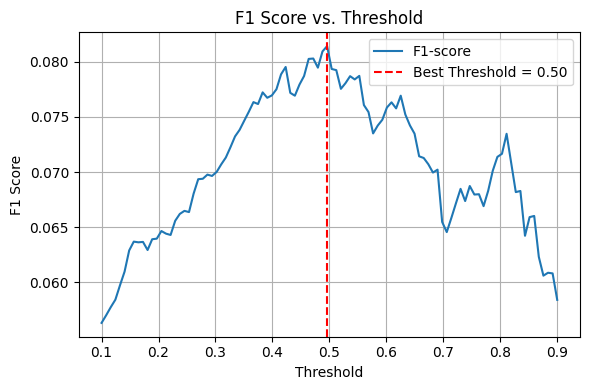

In [ ]:
# ==== In các độ đo ====
print(f"✅ Best Threshold: {best_threshold:.4f}")
print(f"F1-score       : {f1_score(y_test, y_pred_opt):.4f}")
print(f"Precision      : {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall         : {recall_score(y_test, y_pred_opt):.4f}")
print(f"AUC ROC        : {roc_auc_score(y_test, y_probs):.4f}")
print(f"PR AUC         : {pr_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

# ==== Biểu đồ F1 theo threshold ====
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

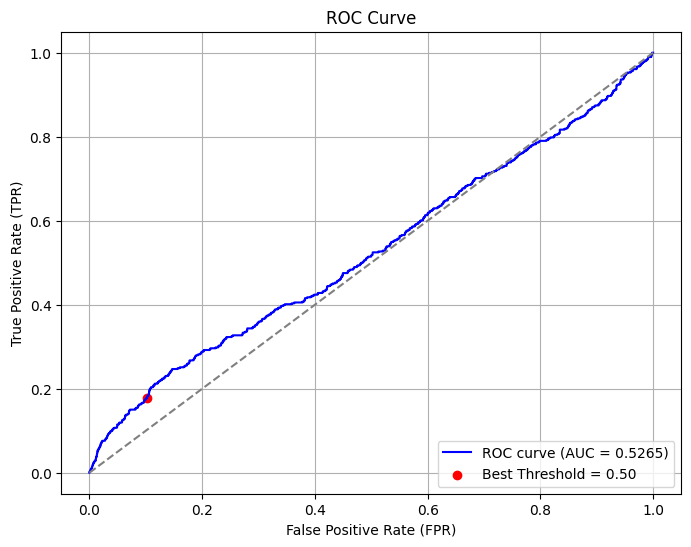

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Tính FPR, TPR và thresholds của ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)

# Tính AUC ROC
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Đường chéo tham khảo

# Vẽ điểm tương ứng với threshold tối ưu (best_threshold)
# Tìm index gần nhất của best_threshold trong roc_thresholds
best_idx = (np.abs(roc_thresholds - best_threshold)).argmin()
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


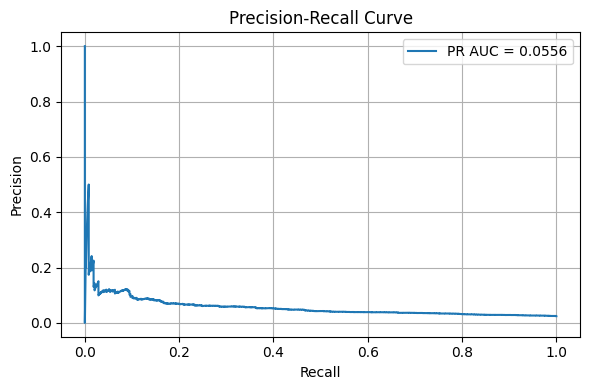

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


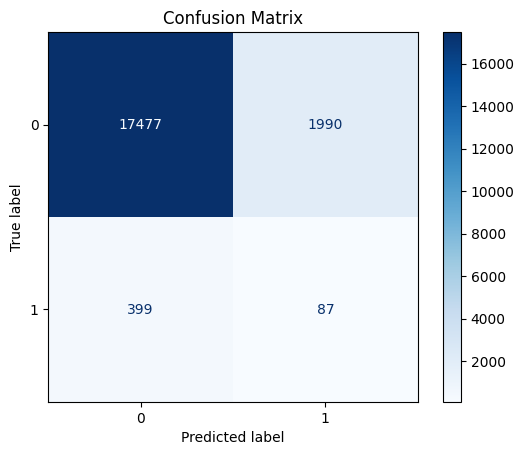

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
result['XGBoost'] = {
    'Precision': precision_score(y_test, y_pred_opt),
    'Recall': recall_score(y_test, y_pred_opt),
    'F1 Score': f1_score(y_test, y_pred_opt),
}

## CatBoost - đã xử lí imbalanced - A - A - No Kfold

Dùng Optuna 

In [19]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
category_columns = ['Stock class','BRAND_CD','Ship Mode','Order date','SUPPLIER_DIV','LOGICAL PLANT','OTHER AREA SHIP DIV','SPECIAL DIV','DELI_DIV']
# 1. X và y từ bản encode gốc
X_all = full_data_4_6.drop(columns=['label'])
# Áp dụng encode toàn bộ trước
y_all = full_data_4_6['label'].astype(int)
print("X_all shape:", X_all.shape)
# 2. Tách chỉ số index cho train/test (80/20)
train_idx, temp_idx = train_test_split(
    X_all.index,
    test_size=0.4,   # 40% còn lại
    random_state=42,
    stratify=y_all
)

# Tách temp_idx thành validation 20% và test 20%
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,   # chia đôi temp_idx thành 20% val + 20% test
    random_state=42,
    stratify=y_all.loc[temp_idx]
)
print(f"Train size: {len(train_idx)} ({len(train_idx)/len(X_all)*100:.1f}%)")
print(f"Validation size: {len(val_idx)} ({len(val_idx)/len(X_all)*100:.1f}%)")
print(f"Test size: {len(test_idx)} ({len(test_idx)/len(X_all)*100:.1f}%)")

# 3. Chuẩn bị df_train 
df_train = full_data_4_6.loc[train_idx].copy()
# Áp dụng remove outliers cho df_train
df_train = remove_outliers_iqr(df_train, number)
# Ap dụng undersampling
df_train_under = apply_random_undersampling(
    df_train,
    label_col='label',
    desired_ratio=1/20
)
# Áp dụng encode cho df_train_under
X_train = df_train_under.drop(columns=['label'])
y_train = df_train_under['label'].astype(int)

# 4. Chuẩn bị df_val 
df_val = full_data_4_6.loc[val_idx].copy()
X_val = df_val.drop(columns=['label'])
y_val = df_val['label'].astype(int)

# 5. Chuẩn bị df_test
df_test = full_data_4_6.loc[test_idx].copy()
X_test = df_test.drop(columns=['label'])
y_test = df_test['label'].astype(int)

# Tạo lại Pool cho val/test nếu dùng CatBoost
val_pool = Pool(X_val, y_val, cat_features=category_columns)
test_pool = Pool(X_test, y_test, cat_features=category_columns)
train_pool = Pool(X_train, y_train, cat_features=category_columns)
# In kết quả để kiểm tra
print("Train size (after undersample):", X_train.shape)
print("Validation size (raw data):", X_val.shape)
print("Test size (raw data):", X_test.shape)


X_all shape: (399053, 13)
Train size: 239431 (60.0%)
Validation size: 79811 (20.0%)
Test size: 79811 (20.0%)
Train size (after undersample): (62685, 13)
Validation size (raw data): (79811, 13)
Test size (raw data): (79811, 13)


In [42]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Hàm mục tiêu cho Optuna
def objective(trial):
    # Hyperparameters cần tối ưu
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'eval_metric': 'F1',
        'verbose': 0,
        'task_type': 'CPU',  # hoặc 'GPU' nếu bạn dùng GPU
        "class_weights": [1.0, 20.0],
        'early_stopping_rounds': 30,
    }

    model = CatBoostClassifier(**params)
    model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=30
    )

    preds = model.predict(X_val)
    return f1_score(y_val, preds)


In [43]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)

[I 2025-05-22 09:27:16,004] A new study created in memory with name: no-name-e10bee04-003e-4cbc-bd4d-0769798ee8c9
[I 2025-05-22 09:27:26,673] Trial 0 finished with value: 0.2214330808080808 and parameters: {'learning_rate': 0.17362141838705078, 'depth': 8, 'l2_leaf_reg': 3.1217723208876174, 'border_count': 205, 'random_strength': 8.843306951802363}. Best is trial 0 with value: 0.2214330808080808.
[I 2025-05-22 09:27:32,661] Trial 1 finished with value: 0.21879142300194931 and parameters: {'learning_rate': 0.24985785711410705, 'depth': 9, 'l2_leaf_reg': 3.872021918370507, 'border_count': 48, 'random_strength': 0.8753662668677019}. Best is trial 0 with value: 0.2214330808080808.
[I 2025-05-22 09:27:41,580] Trial 2 finished with value: 0.21964880411746895 and parameters: {'learning_rate': 0.20195614741745704, 'depth': 6, 'l2_leaf_reg': 3.392159127399413, 'border_count': 125, 'random_strength': 4.238567537392492}. Best is trial 0 with value: 0.2214330808080808.
[I 2025-05-22 09:27:49,710] 

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np

# Lấy params tốt nhất từ Optuna
best_params = study.best_trial.params

# Thêm các tham số cố định nếu cần
best_params.update({
    'n_estimators': 10000,
    'eval_metric': 'F1',  
    'random_state': 42,
})

# Khởi tạo mô hình XGBoost
best_model = CatBoostClassifier(**best_params)

# Huấn luyện mô hình
best_model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=False
)

# Lấy xác suất dự đoán
y_probs = best_model.predict_proba(X_test)[:, 1]

# ===== Tối ưu threshold theo F1 =====
val_probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_val, val_probs >= t) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f'Best threshold: {best_threshold:.3f}')

# Dự đoán với threshold tối ưu
y_pred_opt = (y_probs >= best_threshold).astype(int)

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

Best threshold: 0.399


✅ Best Threshold: 0.3990
F1-score       : 0.0650
Precision      : 0.0339
Recall         : 0.7922
AUC ROC        : 0.6142
PR AUC         : 0.4156

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.44      0.61     19467
           1       0.03      0.79      0.06       486

    accuracy                           0.44     19953
   macro avg       0.51      0.61      0.34     19953
weighted avg       0.96      0.44      0.59     19953



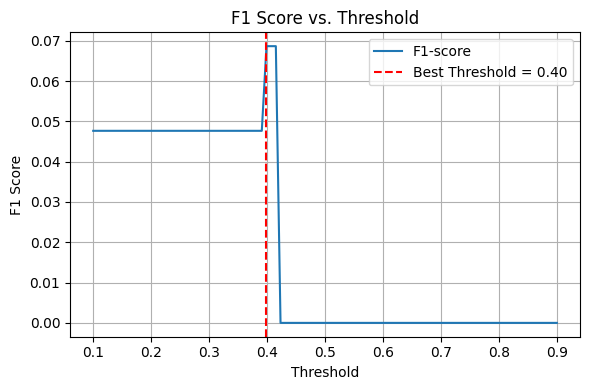

In [148]:
# ==== In các độ đo ====
print(f"✅ Best Threshold: {best_threshold:.4f}")
print(f"F1-score       : {f1_score(y_test, y_pred_opt):.4f}")
print(f"Precision      : {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall         : {recall_score(y_test, y_pred_opt):.4f}")
print(f"AUC ROC        : {roc_auc_score(y_test, y_probs):.4f}")
print(f"PR AUC         : {pr_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

# ==== Biểu đồ F1 theo threshold ====
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

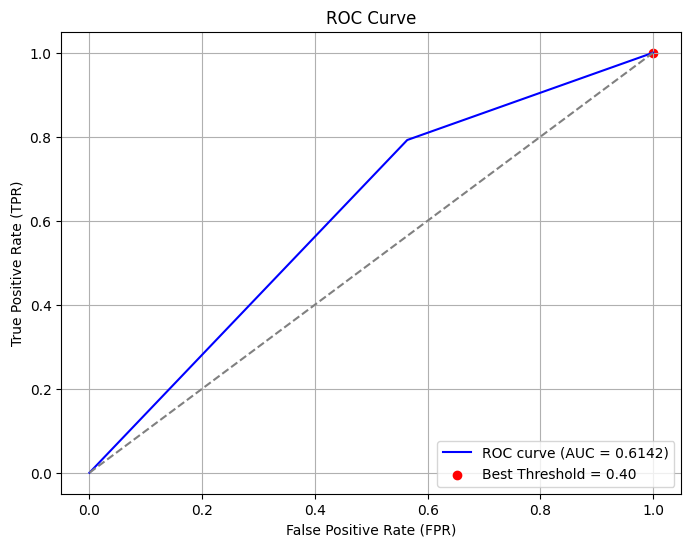

In [149]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Tính FPR, TPR và thresholds của ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)

# Tính AUC ROC
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Đường chéo tham khảo

# Vẽ điểm tương ứng với threshold tối ưu (best_threshold)
# Tìm index gần nhất của best_threshold trong roc_thresholds
best_idx = (np.abs(roc_thresholds - best_threshold)).argmin()
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


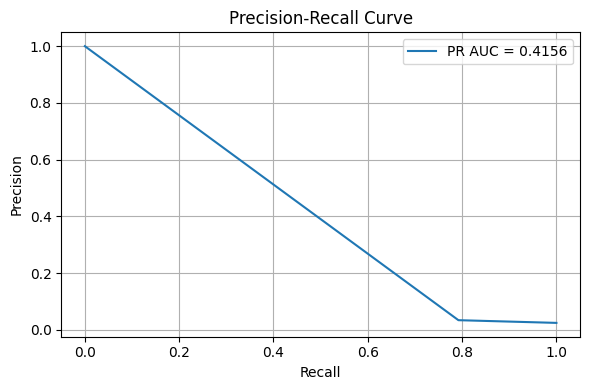

In [150]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


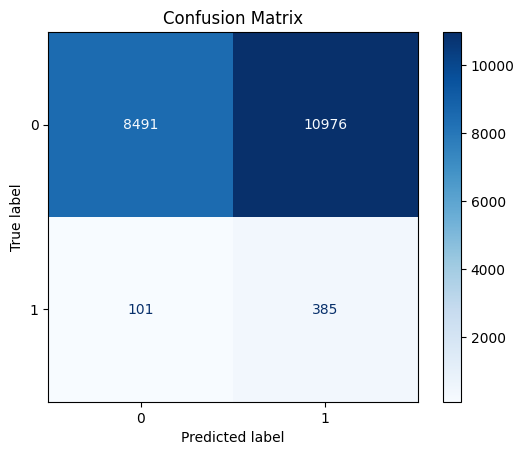

In [151]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [152]:
result['CatBoost_IB_A_A'] = {
    'Precision': precision_score(y_test, y_pred_opt),
    'Recall': recall_score(y_test, y_pred_opt),
    'F1 Score': f1_score(y_test, y_pred_opt),
}

## CatBoost - đã xử lí imbalanced - A - B - No Kfold

In [20]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
category_columns = ['Stock class','BRAND_CD','Ship Mode','Order date','SUPPLIER_DIV','LOGICAL PLANT','OTHER AREA SHIP DIV','SPECIAL DIV','DELI_DIV']
# 1. X và y từ bản encode gốc
X_all = full_data_4_6.drop(columns=['label'])
# Áp dụng encode toàn bộ trước
y_all = full_data_4_6['label'].astype(int)
print("X_all shape:", X_all.shape)
# 2. Tách chỉ số index cho train/test (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)
print("Train size (raw data):", X_train.shape)
print("Val size (raw data):", y_train.shape)

# 3. Chuẩn bị df_train 
df_train = pd.concat([X_train, y_train], axis=1)
# Áp dụng remove outliers cho df_train
df_train = remove_outliers_iqr(df_train, number)
# Ap dụng undersampling cho df_train
df_train = apply_random_undersampling(
    df_train,
    label_col='label',
    desired_ratio=1/20
)

X_train = df_train.drop(columns=['label'])
y_train = df_train['label'].astype(int)

# 4. Chuẩn bị df_val 
df_val = pd.concat([X_val, y_val], axis=1)
X_val = df_val.drop(columns=['label'])
y_val = df_val['label'].astype(int)

# 5. Chuẩn bị df_test
df_test = full_data_7_9.copy()
X_test = df_test.drop(columns=['label'])
y_test = df_test['label'].astype(int)

# Tạo lại Pool cho val/test nếu dùng CatBoost
val_pool = Pool(X_val, y_val, cat_features=category_columns)
test_pool = Pool(X_test, y_test, cat_features=category_columns)
train_pool = Pool(X_train, y_train, cat_features=category_columns)
# In kết quả để kiểm tra
print("Train size (after undersample):", X_train.shape)
print("Validation size (raw data):", X_val.shape)
print("Test size (raw data):", X_test.shape)


X_all shape: (399053, 13)
Train size (raw data): (319242, 13)
Val size (raw data): (319242,)
Train size (after undersample): (83958, 13)
Validation size (raw data): (79811, 13)
Test size (raw data): (1074897, 13)


In [154]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Hàm mục tiêu cho Optuna
def objective(trial):
    # Hyperparameters cần tối ưu
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'eval_metric': 'F1',
        'verbose': 0,
        'task_type': 'CPU',  # hoặc 'GPU' nếu bạn dùng GPU
        "class_weights": [1.0, 20.0],
        'early_stopping_rounds': 30,
    }

    model = CatBoostClassifier(**params)
    model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=30
    )

    preds = model.predict(X_val)
    return f1_score(y_val, preds)


In [155]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)

[I 2025-05-21 17:59:56,353] A new study created in memory with name: no-name-5a0e0026-40f2-414d-8e76-b8e5585c0e4e
[I 2025-05-21 18:00:40,499] Trial 0 finished with value: 0.21980183042129944 and parameters: {'learning_rate': 0.05115044395676922, 'depth': 6, 'l2_leaf_reg': 1.4314945371572518, 'border_count': 52, 'random_strength': 7.974262406974972}. Best is trial 0 with value: 0.21980183042129944.
[I 2025-05-21 18:01:00,777] Trial 1 finished with value: 0.2095414940722754 and parameters: {'learning_rate': 0.17699499418424852, 'depth': 4, 'l2_leaf_reg': 4.182707209920034, 'border_count': 103, 'random_strength': 3.497559057263404}. Best is trial 0 with value: 0.21980183042129944.
[I 2025-05-21 18:01:53,211] Trial 2 finished with value: 0.20383215438500102 and parameters: {'learning_rate': 0.018529866331149936, 'depth': 7, 'l2_leaf_reg': 9.63826407638492, 'border_count': 100, 'random_strength': 2.461326229134719}. Best is trial 0 with value: 0.21980183042129944.
[I 2025-05-21 18:02:50,661

Best trial:
FrozenTrial(number=34, state=1, values=[0.25899557436982873], datetime_start=datetime.datetime(2025, 5, 21, 18, 13, 9, 739301), datetime_complete=datetime.datetime(2025, 5, 21, 18, 13, 43, 596371), params={'learning_rate': 0.17304487144826144, 'depth': 10, 'l2_leaf_reg': 9.411266298041353, 'border_count': 218, 'random_strength': 9.304740065896961}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'border_count': IntDistribution(high=255, log=False, low=32, step=1), 'random_strength': FloatDistribution(high=10.0, log=False, low=1e-09, step=None)}, trial_id=34, value=None)


In [156]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np

# Lấy params tốt nhất từ Optuna
best_params = study.best_trial.params

# Thêm các tham số cố định nếu cần
best_params.update({
    'n_estimators': 1000,
    'eval_metric': 'F1',  
    'random_state': 42,
})

# Khởi tạo mô hình XGBoost
best_model = CatBoostClassifier(**best_params)

# Huấn luyện mô hình
best_model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=False
)

# Lấy xác suất dự đoán
y_probs = best_model.predict_proba(X_test)[:, 1]

# ===== Tối ưu threshold theo F1 =====
val_probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_val, val_probs >= t) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f'Best threshold: {best_threshold:.3f}')

# Dự đoán với threshold tối ưu
y_pred_opt = (y_probs >= best_threshold).astype(int)

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

Best threshold: 0.342


✅ Best Threshold: 0.3424
F1-score       : 0.1740
Precision      : 0.2162
Recall         : 0.1456
AUC ROC        : 0.7251
PR AUC         : 0.1116

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98   1048680
           1       0.22      0.15      0.17     26217

    accuracy                           0.97   1074897
   macro avg       0.60      0.57      0.58   1074897
weighted avg       0.96      0.97      0.96   1074897



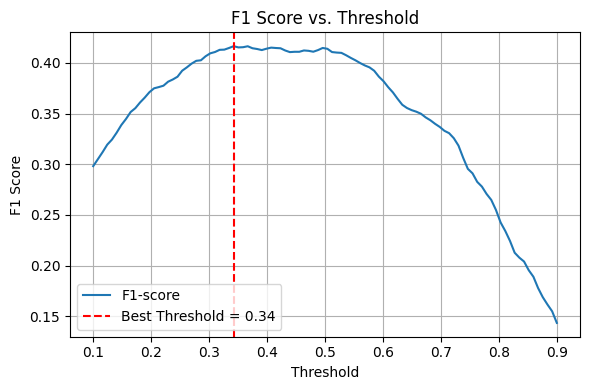

In [162]:
# ==== In các độ đo ====
print(f"✅ Best Threshold: {best_threshold:.4f}")
print(f"F1-score       : {f1_score(y_test, y_pred_opt):.4f}")
print(f"Precision      : {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall         : {recall_score(y_test, y_pred_opt):.4f}")
print(f"AUC ROC        : {roc_auc_score(y_test, y_probs):.4f}")
print(f"PR AUC         : {pr_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

# ==== Biểu đồ F1 theo threshold ====
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

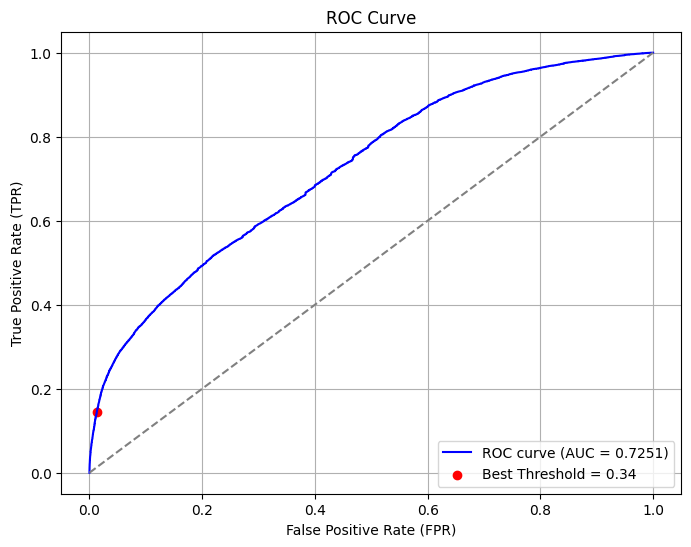

In [163]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Tính FPR, TPR và thresholds của ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)

# Tính AUC ROC
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Đường chéo tham khảo

# Vẽ điểm tương ứng với threshold tối ưu (best_threshold)
# Tìm index gần nhất của best_threshold trong roc_thresholds
best_idx = (np.abs(roc_thresholds - best_threshold)).argmin()
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


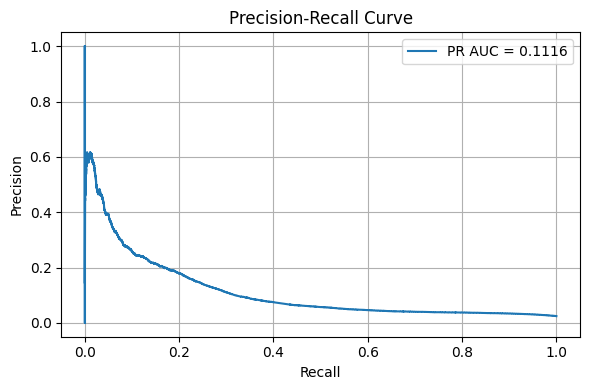

In [164]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


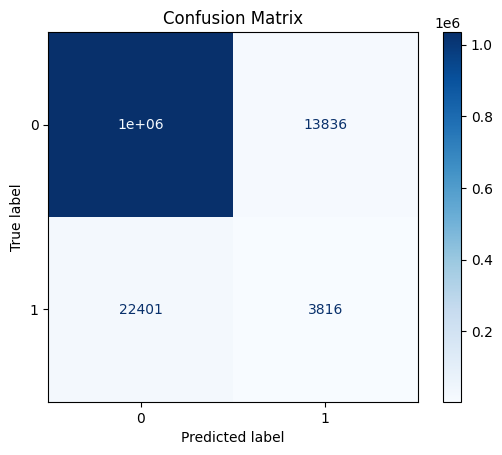

In [165]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [166]:
result['CatBoost_IB_A_B'] = {
    'Precision': precision_score(y_test, y_pred_opt),
    'Recall': recall_score(y_test, y_pred_opt),
    'F1 Score': f1_score(y_test, y_pred_opt),
}

## CatBoost - đã xử lí imbalanced - B - A - No Kfold

In [21]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
category_columns = ['Stock class','BRAND_CD','Ship Mode','Order date','SUPPLIER_DIV','LOGICAL PLANT','OTHER AREA SHIP DIV','SPECIAL DIV','DELI_DIV']
# 1. X và y từ bản encode gốc
X_all = full_data_7_9.drop(columns=['label'])
# Áp dụng encode toàn bộ trước
y_all = full_data_7_9['label'].astype(int)
print("X_all shape:", X_all.shape)
# 2. Tách chỉ số index cho train/test (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)
print("Train size (raw data):", X_train.shape)
print("Val size (raw data):", y_train.shape)

# 3. Chuẩn bị df_train 
df_train = pd.concat([X_train, y_train], axis=1)
# Áp dụng remove outliers cho df_train
df_train = remove_outliers_iqr(df_train, number)
# Ap dụng undersampling cho df_train
df_train = apply_random_undersampling(
    df_train,
    label_col='label',
    desired_ratio=1/20
)

X_train = df_train.drop(columns=['label'])
y_train = df_train['label'].astype(int)

# 4. Chuẩn bị df_val 
df_val = pd.concat([X_val, y_val], axis=1)
X_val = df_val.drop(columns=['label'])
y_val = df_val['label'].astype(int)

# 5. Chuẩn bị df_test
df_test = full_data_4_6.copy()
X_test = df_test.drop(columns=['label'])
y_test = df_test['label'].astype(int)

# Tạo lại Pool cho val/test nếu dùng CatBoost
val_pool = Pool(X_val, y_val, cat_features=category_columns)
test_pool = Pool(X_test, y_test, cat_features=category_columns)
train_pool = Pool(X_train, y_train, cat_features=category_columns)
# In kết quả để kiểm tra
print("Train size (after undersample):", X_train.shape)
print("Validation size (raw data):", X_val.shape)
print("Test size (raw data):", X_test.shape)


X_all shape: (1074897, 13)
Train size (raw data): (859917, 13)
Val size (raw data): (859917,)
Train size (after undersample): (206409, 13)
Validation size (raw data): (214980, 13)
Test size (raw data): (399053, 13)


In [168]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Hàm mục tiêu cho Optuna
def objective(trial):
    # Hyperparameters cần tối ưu
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'eval_metric': 'F1',
        'verbose': 0,
        'task_type': 'CPU',  # hoặc 'GPU' nếu bạn dùng GPU
        "class_weights": [1.0, 20.0],
        'early_stopping_rounds': 30,
    }

    model = CatBoostClassifier(**params)
    model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=30
    )

    preds = model.predict(X_val)
    return f1_score(y_val, preds)


In [169]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)

[I 2025-05-21 18:25:22,241] A new study created in memory with name: no-name-c23a2fd8-a2f1-4137-bea4-076926db37ec
[I 2025-05-21 18:26:27,742] Trial 0 finished with value: 0.30420406235238545 and parameters: {'learning_rate': 0.016969844134390837, 'depth': 8, 'l2_leaf_reg': 5.982150215968832, 'border_count': 146, 'random_strength': 7.210591851755464}. Best is trial 0 with value: 0.30420406235238545.
[I 2025-05-21 18:27:37,170] Trial 1 finished with value: 0.33361247358136936 and parameters: {'learning_rate': 0.047112691166772976, 'depth': 8, 'l2_leaf_reg': 1.3040594648619257, 'border_count': 159, 'random_strength': 9.970629540346309}. Best is trial 1 with value: 0.33361247358136936.
[I 2025-05-21 18:28:32,560] Trial 2 finished with value: 0.3274439601494396 and parameters: {'learning_rate': 0.09383892685756999, 'depth': 10, 'l2_leaf_reg': 7.987745644902434, 'border_count': 73, 'random_strength': 5.382529173433678}. Best is trial 1 with value: 0.33361247358136936.
[I 2025-05-21 18:29:01,

Best trial:
FrozenTrial(number=28, state=1, values=[0.35585821547057794], datetime_start=datetime.datetime(2025, 5, 21, 18, 40, 3, 88380), datetime_complete=datetime.datetime(2025, 5, 21, 18, 40, 34, 464057), params={'learning_rate': 0.21618270809530185, 'depth': 10, 'l2_leaf_reg': 9.02058843786363, 'border_count': 113, 'random_strength': 3.187732236804214}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'border_count': IntDistribution(high=255, log=False, low=32, step=1), 'random_strength': FloatDistribution(high=10.0, log=False, low=1e-09, step=None)}, trial_id=28, value=None)


In [170]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np

# Lấy params tốt nhất từ Optuna
best_params = study.best_trial.params

# Thêm các tham số cố định nếu cần
best_params.update({
    'n_estimators': 1000,
    'eval_metric': 'F1',  
    'random_state': 42,
})

# Khởi tạo mô hình XGBoost
best_model = CatBoostClassifier(**best_params)

# Huấn luyện mô hình
best_model.fit(
    train_pool,
    eval_set=val_pool,
    verbose=False
)

# Lấy xác suất dự đoán
y_probs = best_model.predict_proba(X_test)[:, 1]

# ===== Tối ưu threshold theo F1 =====
val_probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_val, val_probs >= t) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f'Best threshold: {best_threshold:.3f}')

# Dự đoán với threshold tối ưu
y_pred_opt = (y_probs >= best_threshold).astype(int)

precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

Best threshold: 0.641


✅ Best Threshold: 0.6414
F1-score       : 0.1393
Precision      : 0.3179
Recall         : 0.0892
AUC ROC        : 0.6754
PR AUC         : 0.0845

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    389320
           1       0.32      0.09      0.14      9733

    accuracy                           0.97    399053
   macro avg       0.65      0.54      0.56    399053
weighted avg       0.96      0.97      0.97    399053



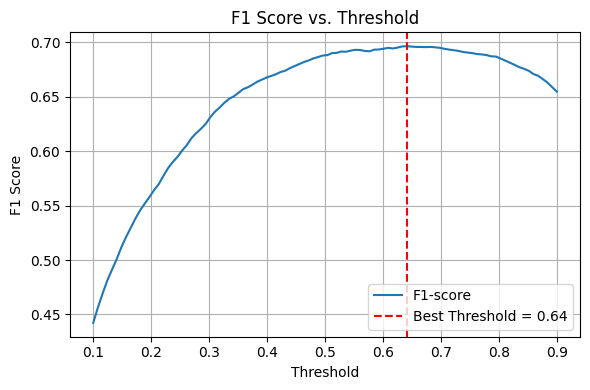

In [171]:
# ==== In các độ đo ====
print(f"✅ Best Threshold: {best_threshold:.4f}")
print(f"F1-score       : {f1_score(y_test, y_pred_opt):.4f}")
print(f"Precision      : {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall         : {recall_score(y_test, y_pred_opt):.4f}")
print(f"AUC ROC        : {roc_auc_score(y_test, y_probs):.4f}")
print(f"PR AUC         : {pr_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

# ==== Biểu đồ F1 theo threshold ====
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

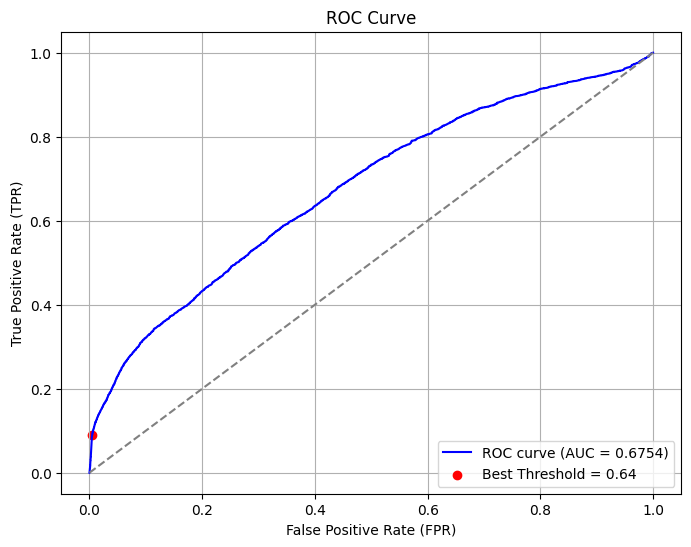

In [172]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Tính FPR, TPR và thresholds của ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)

# Tính AUC ROC
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Đường chéo tham khảo

# Vẽ điểm tương ứng với threshold tối ưu (best_threshold)
# Tìm index gần nhất của best_threshold trong roc_thresholds
best_idx = (np.abs(roc_thresholds - best_threshold)).argmin()
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


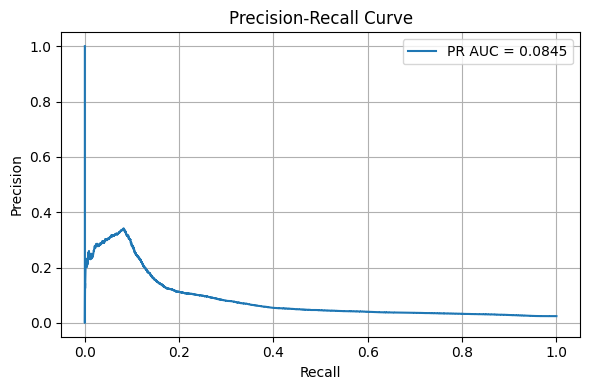

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

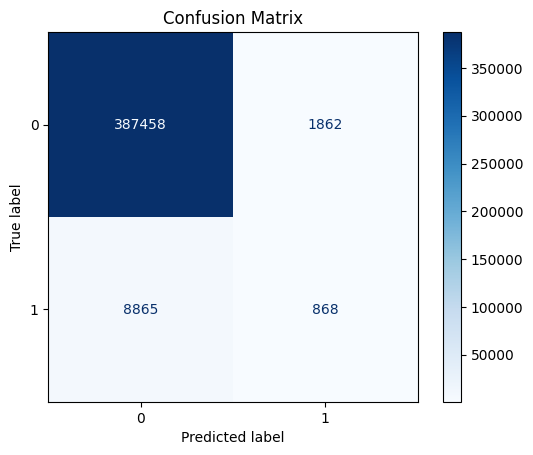

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
result['CatBoost_IB_B_A'] = {
    'Precision': precision_score(y_test, y_pred_opt),
    'Recall': recall_score(y_test, y_pred_opt),
    'F1 Score': f1_score(y_test, y_pred_opt),
}

## CatBoost - đã xử lí imbalanced - train: A + k%B -> test (1-k)%B - No Kfold

## CatBoost - đã xử lí imbalanced - AB - Kfold 5

Dùng Optuna 

In [44]:
from sklearn.model_selection import train_test_split
from catboost import Pool

from sklearn.model_selection import train_test_split

# 1. X và y từ bản encode gốc
X_all = df_full_data.drop(columns=['label'])
y_all = df_full_data['label'].astype(int)

# 2. Tách chỉ số index cho train/test (80/20)
train_idx, test_idx = train_test_split(
    X_all.index,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)
print("Train size (raw data):", len(train_idx))
# 3. Chuẩn bị df_train từ bản cleaned + encoded
df_train = df_full_data.loc[train_idx].copy()

# Áp dụng remove outliers cho df_train
df_train = remove_outliers_iqr(df_train, number)

# --- Áp dụng undersampling lên df_train (cần cả label) ---
df_train_under = apply_random_undersampling(
    df_train,
    label_col='label',
    desired_ratio=1/20 
)

# Tạo tập validation từ df_train_under
X_train = df_train_under.drop(columns=['label'])
y_train = df_train_under['label'].astype(int)


# 5. Lấy X_test, y_test từ bản gốc encode (chưa clean, chưa undersample)
df_test = df_full_data.loc[test_idx]
X_test = df_test.drop(columns=['label'])
y_test = df_test['label'].astype(int)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

# In kết quả để kiểm tra
print("Train size (after undersample):", X_train.shape)
print("Test size (raw data):         ", X_test.shape)


# Danh sách các cột phân loại
category_columns = ['Stock class','BRAND_CD','Ship Mode','Order date','SUPPLIER_DIV','LOGICAL PLANT','OTHER AREA SHIP DIV','SPECIAL DIV','DELI_DIV']

# Tạo Pool cho CatBoost
train_pool = Pool(data=X_train, label=y_train, cat_features=category_columns)
val_pool = Pool(data=X_val, label=y_val, cat_features=category_columns)
test_pool = Pool(data=X_test, label=y_test, cat_features=category_columns)


Train size (raw data): 1179160
Train size (after undersample): (289422, 13)
Test size (raw data):          (294790, 13)


In [48]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
import optuna
import numpy as np
from functools import partial

# Chuẩn bị dữ liệu đầu vào cho objective
X = X_train.reset_index(drop=True)
y = y_train.reset_index(drop=True)

def objective(trial, X, y):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'eval_metric': 'Logloss',  # Dùng logloss hoặc AUC
        'verbose': 0,
        'task_type': 'CPU',
        'class_weights': {0: 1, 1: 20},
        'early_stopping_rounds': 30,
    }

    skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=category_columns)
        valid_pool = Pool(X_val, y_val, cat_features=category_columns)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

        preds = model.predict(X_val)
        score = f1_score(y_val, preds.astype(int))
        f1_scores.append(score)

    return np.mean(f1_scores)

# Tạo partial để truyền X, y vào objective
optuna_objective = partial(objective, X=X, y=y)

study = optuna.create_study(direction='maximize')
study.optimize(optuna_objective, n_trials=5)

print("Best F1:", study.best_value)
print("Best params:", study.best_params)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
import optuna
import numpy as np
from functools import partial

# Chuẩn bị dữ liệu đầu vào cho objective
X = X_train.reset_index(drop=True)
y = y_train.reset_index(drop=True)

def objective(trial, X, y):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'eval_metric': 'Logloss',  # Dùng logloss hoặc AUC
        'verbose': 0,
        'task_type': 'CPU',
        'class_weights': {0: 1, 1: 20},
        'early_stopping_rounds': 30,
    }

    skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=category_columns)
        valid_pool = Pool(X_val, y_val, cat_features=category_columns)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

        preds = model.predict(X_val)
        score = f1_score(y_val, preds.astype(int))
        f1_scores.append(score)

    return np.mean(f1_scores)

# Tạo partial để truyền X, y vào objective
optuna_objective = partial(objective, X=X, y=y)

study = optuna.create_study(direction='maximize')
study.optimize(optuna_objective, n_trials=3)

print("Best F1:", study.best_value)
print("Best params:", study.best_params)

[I 2025-06-15 22:05:38,097] A new study created in memory with name: no-name-f979ba49-aea5-49c3-a083-9b8242a45658
[W 2025-06-15 22:15:20,714] Trial 0 failed with parameters: {'learning_rate': 0.09056198117403552, 'depth': 5, 'l2_leaf_reg': 6.743152564909903, 'border_count': 46, 'random_strength': 2.1656581746766843} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\NewDat\Miniconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\NewDat\AppData\Local\Temp\ipykernel_27864\1225063092.py", line 38, in objective
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
  File "c:\Users\NewDat\Miniconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np

# Lấy params tốt nhất từ Optuna
best_params = study.best_trial.params

# Thêm các tham số cố định nếu cần
best_params.update({
    'n_estimators': 1000,
    'eval_metric': 'F1',  
    'random_state': 42,
})

# Khởi tạo mô hình XGBoost
best_model = CatBoostClassifier(**best_params)

# Huấn luyện mô hình
best_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False
)

# Lấy xác suất dự đoán
y_probs = best_model.predict_proba(X_test)[:, 1]

# ===== Tối ưu threshold theo F1 =====
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_test, y_probs >= t) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f'Best threshold: {best_threshold:.3f} with F1 score: {best_f1:.4f}')

# Dự đoán với threshold tối ưu
y_pred_opt = (y_probs >= best_threshold).astype(int)

ValueError: No trials are completed yet.

✅ Best Threshold: 0.5202
F1-score       : 0.6211
Precision      : 0.7323
Recall         : 0.5392
AUC ROC        : 0.9230

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    287600
           1       0.73      0.54      0.62      7190

    accuracy                           0.98    294790
   macro avg       0.86      0.77      0.81    294790
weighted avg       0.98      0.98      0.98    294790



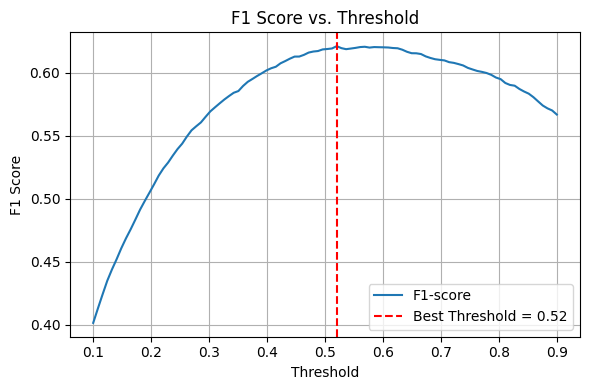

In [ ]:
# ==== In các độ đo ====
print(f"✅ Best Threshold: {best_threshold:.4f}")
print(f"F1-score       : {f1_score(y_test, y_pred_opt):.4f}")
print(f"Precision      : {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall         : {recall_score(y_test, y_pred_opt):.4f}")
print(f"AUC ROC        : {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

# ==== Biểu đồ F1 theo threshold ====
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

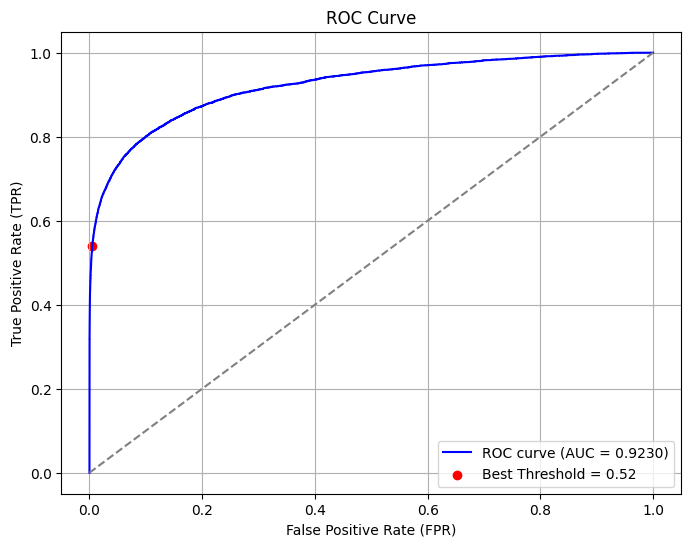

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Tính FPR, TPR và thresholds của ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)

# Tính AUC ROC
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Đường chéo tham khảo

# Vẽ điểm tương ứng với threshold tối ưu (best_threshold)
# Tìm index gần nhất của best_threshold trong roc_thresholds
best_idx = (np.abs(roc_thresholds - best_threshold)).argmin()
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


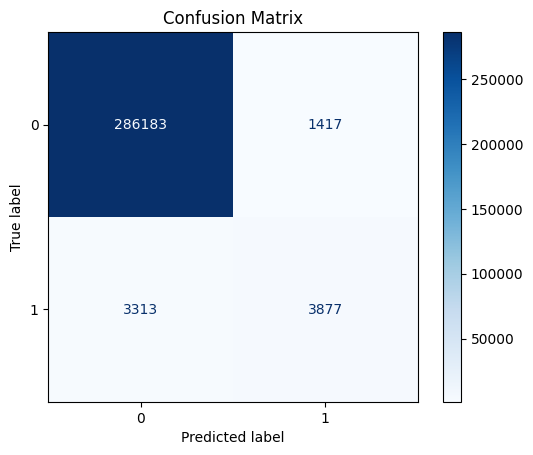

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
result['CatBoost_IB_AB'] = {
    'Precision': precision_score(y_test, y_pred_opt),
    'Recall': recall_score(y_test, y_pred_opt),
    'F1 Score': f1_score(y_test, y_pred_opt),
}

In [ ]:
# Sau khi bạn tìm được best_threshold
model_file = "catboost_model.cbm"
threshold_file = "catboost_threshold.txt"

# Lưu mô hình
best_model.save_model(model_file)

# Lưu threshold vào một file văn bản
with open(threshold_file, "w") as f:
    f.write(str(best_threshold))

print("Model and threshold successfully saved.")


Model and threshold successfully saved.


In [ ]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

# Cột phân loại
category_columns = ['Stock class','BRAND_CD','Ship Mode','Order date','SUPPLIER_DIV','LOGICAL PLANT','OTHER AREA SHIP DIV','SPECIAL DIV','DELI_DIV']

# Các giá trị k muốn thử
k_values = [10, 30, 50, 70, 90]

# Duyệt qua các giá trị k
for k_percent in k_values:
    print(f"\n==== Running for test set = {k_percent}% ====")
    # Chia dữ liệu
     # Tổng số bản ghi 7_9 raw
    total_7_9 = len(full_data_7_9)
    test_size = int(total_7_9 * (k_percent / 100))
    train_size = total_7_9 - test_size

    # Shuffle để lấy mẫu ngẫu nhiên
    df_7_9_shuffled = full_data_7_9.sample(frac=1, random_state=42).reset_index(drop=True)

    # Tách test và phần train từ tháng 7_9
    df_test = df_7_9_shuffled.iloc[:test_size].copy()           # <- giữ nguyên, không clean
    df_train_7_9_clean_part = full_data_7_9_cleaned.sample(n=train_size, random_state=42)  # <- phần clean tương ứng

    # Gộp với df_train_4_6_clean để tạo tập train đầy đủ
    df_train_full = pd.concat([full_data_4_6_cleaned, df_train_7_9_clean_part], ignore_index=True) 

    # Áp dụng undersampling
    df_train_under = apply_random_undersampling(df_train_full, label_col='label', desired_ratio=1/20)

    # Tách X, y
    X_train = df_train_under.drop(columns=['label'])
    y_train = df_train_under['label'].astype(int)

    X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
    )  

    X_test = df_test.drop(columns=['label'])
    y_test = df_test['label'].astype(int)

    # Tạo Pool
    train_pool = Pool(data=X_tr, label=y_tr, cat_features=category_columns)
    val_pool = Pool(data=X_val, label=y_val, cat_features=category_columns)
    test_pool = Pool(data=X_test, label=y_test, cat_features=category_columns)

    # Hàm mục tiêu Optuna
    def objective(trial):
    # Hyperparameters cần tối ưu
        params = {
            'iterations': 1000,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
            'eval_metric': 'F1',
            'verbose': 0,
            'task_type': 'CPU',  # hoặc 'GPU' nếu bạn dùng GPU
            'class_weights': {0: 1, 1: 20},
            'early_stopping_rounds': 30,
        }

        model = CatBoostClassifier(**params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True
        )

        preds = model.predict(X_test)
        return f1_score(y_test, preds)

    # Tối ưu với Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=5)

    print("Best trial:")
    print(study.best_trial)

    # Lấy params tốt nhất từ Optuna
    best_params = study.best_trial.params

    # Thêm các tham số cố định nếu cần
    best_params.update({
        'n_estimators': 1000,
        'eval_metric': 'logloss',  # XGBoost không có f1 làm eval_metric trực tiếp
        'random_state': 42,
    })

    # Khởi tạo mô hình XGBoost
    best_model = CatBoostClassifier(**best_params)

    # Huấn luyện mô hình
    best_model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=False
    )

    # Lấy xác suất dự đoán
    y_probs = best_model.predict_proba(X_test)[:, 1]

    # ===== Tối ưu threshold theo F1 =====
    thresholds = np.linspace(0.1, 0.9, 100)
    f1_scores = [f1_score(y_test, y_probs >= t) for t in thresholds]

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    print(f'Best threshold: {best_threshold:.3f} with F1 score: {best_f1:.4f}')

    # Dự đoán với threshold tối ưu
    y_pred_opt = (y_probs >= best_threshold).astype(int)

    # ==== In các độ đo ====
    print(f"✅ Best Threshold: {best_threshold:.4f}")
    print(f"F1-score       : {f1_score(y_test, y_pred_opt):.4f}")
    print(f"Precision      : {precision_score(y_test, y_pred_opt):.4f}")
    print(f"Recall         : {recall_score(y_test, y_pred_opt):.4f}")
    print(f"AUC ROC        : {roc_auc_score(y_test, y_probs):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

    # ==== Biểu đồ F1 theo threshold ====
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, f1_scores, label='F1-score')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Tính FPR, TPR và thresholds của ROC
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)

    # Tính AUC ROC
    auc_score = roc_auc_score(y_test, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Đường chéo tham khảo

    # Vẽ điểm tương ứng với threshold tối ưu (best_threshold)
    # Tìm index gần nhất của best_threshold trong roc_thresholds
    best_idx = (np.abs(roc_thresholds - best_threshold)).argmin()
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Tính confusion matrix
    cm = confusion_matrix(y_test, y_pred_opt)

    # Hiển thị confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Lưu kết quả vào dictionary
    result[f'CatBoost_k_{k_percent}'] = {
        'Precision': precision_score(y_test, y_pred_opt),
        'Recall': recall_score(y_test, y_pred_opt),
        'F1 Score': f1_score(y_test, y_pred_opt),
    }

# **Nhận xét**

Dựa vào bảng kết quả cho thấy mô hình CatBoost cho kết quả cao nhất so với LightGBM, XGBoost trong thực nghiệm train A test B. Quyết định sử dụng CatBoost cho 4 thực nghiệm tiếp theo cho thấy, Train A test B cho thấy mô hình sẽ ưu tiên recall  => Với độ phủ cao nhưng độ chính xác còn hạn chế, mô hình hiện tại có xu hướng ưu tiên không bỏ sót các đơn hàng bị trễ, chấp nhận việc có thể cảnh báo nhầm một số đơn hàng không bị trễ.

Xét trên bài toán delay, việc bỏ qua các đơn hàng bị delay sẽ dẫn đến những tình huống bất ngờ cho doanh nghiệp, chi phí phát sinh, giảm uy tín của doanh nghiệp đối với đơn vị cung cấp và khách hàng,... => Ta sẽ ưu tiên giảm lỗi FN để mô hình có thể nhận ra được càng nhiều đơn hàng có khả năng bị delay => Ưu tiên Recall hơn. 

Với K tăng dần cho thấy, cả 3 thang đo điểm càng ngày càng giảm, cho thấy mô hình bị overfitting dẫn đến điểm F1 score giảm

Trong tương lai: em sẽ làm thêm các kĩ thuật feature engineering (Tạo ra thuộc tính mới), sử dụng ROC AUC để đánh giá kết quả

In [ ]:
df = pd.DataFrame(result)
df.to_excel("result.xlsx", index=True)